# NYT Comments

Final project for Machine Learning course

In [38]:
import pandas as pd
import numpy as np
import csv
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
import string 
import matplotlib.pyplot as plt

In [39]:
df = pd.read_csv('/Users/.../cleaned_NYT.csv')
df = df[df.columns.difference(['Unnamed: 0'])]
initial_columns = df.columns

In [40]:
## Initializing a stopwords dictionary
stop_words = stopwords.words('english')
for add in ['i', 'is','they', 'are', 'among', 'another', 'sought']:
    stop_words.append(add)
stop_words = list(set(stop_words))

## Also designing my own punctuation list
punctuation = unicode(string.punctuation)
punctuation = punctuation + u'’'+ u'‘'
numbers = u'1234567890'

## Adding a title length column to the dataframe
df['len_title'] = df['title'].apply(lambda x: len(x))

In [41]:
# Now for each title, tokenize and put a dummy var if present
for i in range(df.shape[0] - 1):
    title = df.loc[i, 'title']
    tokenized_title = [w for w in word_tokenize(title.decode('utf-8')) 
                       if (w.lower() not in stop_words) and (w not in punctuation) 
                       and (w[0] not in numbers)]
    for w in tokenized_title:
        if w in df.keys():
            df.loc[i, w] = 1
        else:
            df[w] = pd.Series(np.zeros(df.shape[0]), index=df.index)
            df.loc[i, w] = 1

In [42]:
df.shape

(1686, 4260)

In [43]:
## First columns is the number 86
## Check what are the most frequent words in titles.

word_data = pd.DataFrame.from_dict({}, orient='index')
for num, col in enumerate(df.columns[86:]):
    word_data.loc[num, 'word'] = col
    word_data.loc[num, 'count'] = sum(df.loc[:, col])
    
## Display the most frequent words in the dataset
word_data.sort_values('count')

,word,count
4173,Prepares,1.0
1528,Kept,1.0
1527,Segregation,1.0
3148,Enters,1.0
1525,Stricter,1.0
3150,Roberts,1.0
3151,Jokes,1.0
1522,Irate,1.0
1521,Embassies,1.0
1520,Long-Closed,1.0


# I. FEATURE ENGINEERING

In [44]:
# Filling up missing values with 0        
for col in df.columns:
    if df[col].isnull().sum() != 0:
        df[col].fillna(0, inplace=True)

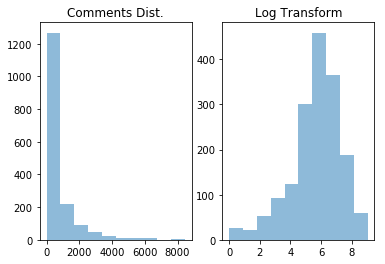

In [45]:
# Need to transform the comments variable
plt.clf()
fig, ax = plt.subplots(ncols=2)
ax[0].hist(df['comments'], alpha = 0.5)
ax[0].set_title('Comments Dist.')
log_comments = [np.log(c) if c != 0 else 0 for c in df['comments']]
ax[1].hist(log_comments, alpha = 0.5)
ax[1].set_title('Log Transform')
plt.show()

['favoritesCount', 'followersCount']
['friendsCount', 'listedCount']
['num_paragraphs', 'number_of_articles']


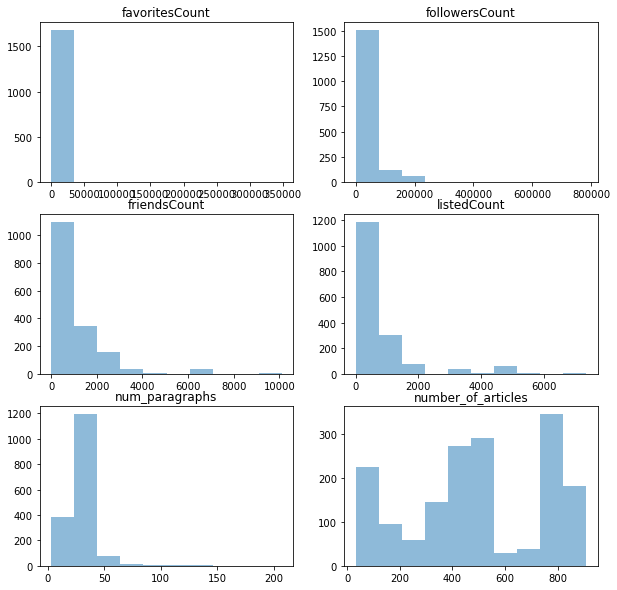

In [46]:
## Plotting all the variables that might need a log transformation
plt.clf()

fig, ax = plt.subplots(ncols=2, nrows = 3)

cols = [['favoritesCount', 'followersCount'], 
        ['friendsCount', 'listedCount'],
        ['num_paragraphs', 'number_of_articles']]

for i in range(0, 3):
    c = cols[i]
    print str(c)
    for j in range(0, 2):
        ax[i][j].hist(df[c[j]], alpha = 0.5)
        ax[i][j].set_title(c[j])

fig.set_figwidth(10)
fig.set_figheight(10)
plt.show()

In [47]:
## Simply taking the log of all the above plotted variables
# Comments variable
for v in ['favoritesCount', 'followersCount','friendsCount', 
          'listedCount','num_paragraphs', 'number_of_articles',
          'comments']:
    df[v] = df[v].apply(lambda x: np.log(x) if x != 0 else 0)

# II. MODELLING
- Simple regression to predict the exact number of comments
- Support Vector Machine to distinguish between highly commented topics and not 


In [48]:
# Keeping track of string columns
string_cols = []
for col in df.columns:
    if df[col].dtype == 'O':
        string_cols.append(col)


In [49]:
## Keep the dataframe with the no string columns
df_no_strings = df[df.columns.difference(string_cols)]

In [50]:
print str(df.shape[1]) + ' ' + str(df_no_strings.shape[1])

4260 4248


## Measures of Overfit and MSE

In [51]:
## Feature selection
from sklearn.feature_selection import SelectKBest
from sklearn.model_selection import train_test_split
from sklearn.feature_selection import f_regression
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score
from sklearn.linear_model import Lasso
from sklearn.linear_model import Ridge

### Feature selection using KBest
r2_measures_linear_reg, r2_measures_lasso, r2_measures_ridge, features_number = [], [], [], []
mse_lasso = []

### Keep the dataframe with no string columns. Also, limiting the number of columns included
for i in range(df_no_strings.shape[1]-3500):

    # Select KBest
    selector = SelectKBest(f_regression, k = 1+i)
    df_no_comments = df_no_strings[df_no_strings.columns.difference(['comments'])]
    selected_features = selector.fit_transform(df_no_comments, df_no_strings['comments'])  
    indexes = selector.get_support(indices = True)                  
    df_features_selected = df_no_comments[df_no_comments.columns[indexes]]
    
    # Now random sampling
    X_train, X_test, y_train, y_test = train_test_split(df_features_selected , df_no_strings['comments'], test_size=0.10)
       
    # Now calling the classifiers
    clf_linreg = LinearRegression()
    clf_lasso = Lasso()
    clf_ridge = Ridge()
    
    # Making the predictions
    predictions_linear = clf_linreg.fit(X_train, y_train).predict(X_test) 
    predictions_ridge = clf_lasso.fit(X_train, y_train).predict(X_test) 
    predictions_lasso = clf_ridge.fit(X_train, y_train).predict(X_test) 
    
    # Calsulating the R2 score for each regression
    r2_fits = [r2_score(y_test, predictions_linear), r2_score(y_test, predictions_ridge), 
               r2_score(y_test, predictions_lasso)]
    
    # Setting to 0 any negative R2 scores
    r2_fits = [score if score>0 else 0 for score in r2_fits ]
    
    # Appending to list of scores
    r2_measures_linear_reg.append(r2_fits[0])
    r2_measures_ridge.append(r2_fits[1])
    r2_measures_lasso.append(r2_fits[2])
    mse_lasso.append(mean_squared_error(y_test, predictions_lasso))
    features_number.append(1+i)

In [52]:
## Calculatin the mean R2 between all the different types of linear regression
mean_r2 = []
for lin, lasso, ridge in zip(r2_measures_linear_reg, r2_measures_lasso, r2_measures_ridge):
    mean_r2.append(np.mean([lin, lasso, ridge]))

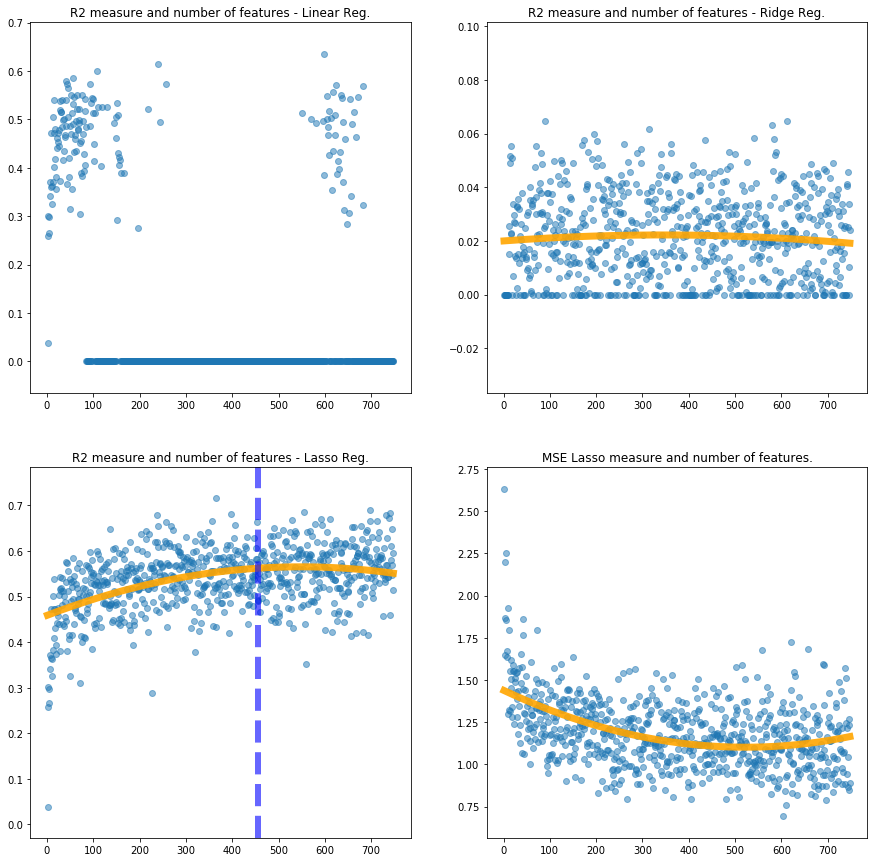

In [75]:
plt.clf()

fig, ax = plt.subplots(ncols=2, nrows=2)

ax[0][0].scatter(features_number, r2_measures_linear_reg, alpha = 0.5)
#ax[0][0].plot(features_number, r2_measures_linear_reg, linestyle = '--', alpha = 0.5)
ax[0][0].set_title('R2 measure and number of features - Linear Reg.')

ax[0][1].scatter(features_number, r2_measures_ridge, alpha = 0.5)
#ax[0][1].plot(features_number, r2_measures_ridge, linestyle = '--', alpha = 0.5)
ax[0][1].set_title('R2 measure and number of features - Ridge Reg.')
fitted_values_ridge = [np.poly1d(np.polyfit(features_number, r2_measures_ridge, 2))(n) for n in features_number]
ax[0][1].plot(features_number, fitted_values_ridge, linewidth = 7, color = 'orange', alpha = 0.9)

ax[1][0].scatter(features_number, r2_measures_lasso, alpha = 0.5)
#ax[1][0].plot(features_number, r2_measures_lasso, linestyle = '--', alpha = 0.5)
ax[1][0].set_title('R2 measure and number of features - Lasso Reg.')
fitted_values_lasso = [np.poly1d(np.polyfit(features_number, r2_measures_lasso, 2))(n) for n in features_number]
ax[1][0].plot(features_number, fitted_values_lasso, linewidth = 7, color = 'orange', alpha = 0.9)
ax[1][0].axvline(455, linestyle = '--', linewidth = 6, color = 'blue', alpha = 0.6)

ax[1][1].scatter(features_number, mse_lasso, alpha = 0.5)
#ax[1][1].plot(features_number, mse_lasso, linestyle = '--', alpha = 0.5)
ax[1][1].set_title('MSE Lasso measure and number of features.')
fitted_values_mse = [np.poly1d(np.polyfit(features_number, mse_lasso, 2))(n) for n in features_number]
ax[1][1].plot(features_number, fitted_values_mse,linewidth = 7, color = 'orange', alpha = 0.9)

fig.set_figwidth(15)
fig.set_figheight(15)
fig.savefig('/Users/dmpierre/Desktop/accuracies_2.jpg')
plt.show()

## III. FEATURE SELECTION

In [54]:
## Inspect also the most important features. We keep only the lasso algorithm
df_no_comments = df_no_strings[df_no_strings.columns.difference(['comments'])]

selector = SelectKBest(f_regression, k = 400)
selected_features = selector.fit_transform(df_no_comments, df_no_strings['comments'])  
indexes = selector.get_support(indices = True)    

# Create a dataframe to store the relevant p-values
p_vals_dict = pd.DataFrame.from_dict({}, orient='index')

# Start at i = 0 for the loop
i = 0    
for idx, pval in zip(indexes, selected_features[1]):
    p_vals_dict.loc[i, 'feature'] = df_no_comments.columns[idx]
    p_vals_dict.loc[i, 'pval'] = pval
    i = i+1
df_features_selected = df_no_comments[df_no_comments.columns[indexes]]


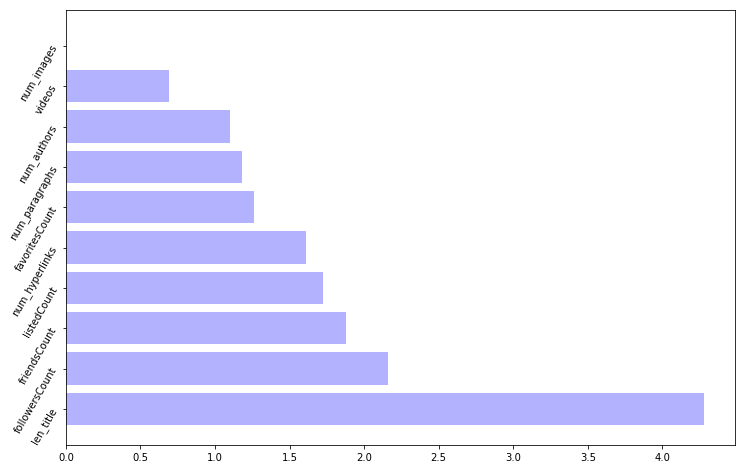

In [132]:
# Plot Horizontal Bar hist
plt.clf()
fig, ax = plt.subplots()

sorted_dict = p_vals_dict.sort_values('pval', ascending = False)
features_names = sorted_dict.iloc[:10,0]
y_pos = np.arange(features_names.shape[0])
p_vals = sorted_dict.iloc[:10, 1]
p_vals = [np.log(p) for p in p_vals]

ax.barh(y_pos, p_vals, align='center', color='blue', alpha = 0.3)
ax.set_yticks(y_pos)
ax.set_yticklabels(features_names)
for tick in ax.get_yticklabels():
    tick.set_rotation(60)
fig.set_figheight(8), fig.set_figwidth(12)
fig.savefig('/Users/dmpierre/Desktop/f_regressionScore.jpg')
plt.show()

## GridSearch parameters of Lasso Model

In [56]:
## Launching GridSearch for the Lasso Regression
# Select KBest first
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import KFold

selector = SelectKBest(f_regression, k = 400)
df_no_comments = df_no_strings[df_no_strings.columns.difference(['comments'])]
selected_features = selector.fit_transform(df_no_comments, df_no_strings['comments'])  
indexes = selector.get_support(indices = True)                  
df_features_selected = df_no_comments[df_no_comments.columns[indexes]]


# Now call the Lasso Regression
clf_lasso = Lasso()
lasso_param_grid = [
    {'alpha': np.arange(0.1, 1.1, 0.1), 'fit_intercept': [True, False], 'normalize':[True, False]}
]

# Launching GridSearch
lasso_gridsearch = GridSearchCV(clf_lasso, lasso_param_grid, 'r2', cv = KFold(n_splits=4))
lasso_gridsearch.fit(df_features_selected, df_no_strings['comments'])

df_results = pd.DataFrame(lasso_gridsearch.cv_results_)
df_results[df_results['rank_test_score']==1]

,mean_fit_time,mean_score_time,mean_test_score,mean_train_score,param_alpha,param_fit_intercept,param_normalize,params,rank_test_score,split0_test_score,...,split1_test_score,split1_train_score,split2_test_score,split2_train_score,split3_test_score,split3_train_score,std_fit_time,std_score_time,std_test_score,std_train_score
2,0.070928,0.000767,0.296348,0.327205,0.1,False,True,"{u'normalize': True, u'alpha': 0.1, u'fit_inte...",1,0.322074,...,0.311066,0.335306,0.314225,0.294802,0.237931,0.336539,0.010123,0.000064,0.033938,0.018886
3,0.060766,0.000743,0.296348,0.327205,0.1,False,False,"{u'normalize': False, u'alpha': 0.1, u'fit_int...",1,0.322074,...,0.311066,0.335306,0.314225,0.294802,0.237931,0.336539,0.006524,0.000035,0.033938,0.018886


# IV. BINARY CLASSIFICATION.
- We will differentiate between midly and highly commented articles and poorly commented ones.

Different regression models seem to perform poorly.

In [57]:
## Assigning the value of 1 to any row where the value of comments is higher than the mean
df_no_strings['high_engagement'] = np.zeros(df_no_strings.shape[0])
df_no_strings.loc[df_no_strings['comments'] > 5.8,'high_engagement']= 1
df_no_strings.loc[:, ['comments', 'high_engagement']]

## Don't forget to take the comments column out. Will make a copy of the dataset. 
df_engagement = df_no_strings[df_no_strings.columns.difference(['comments'])].copy()

/Users/dmpierre/anaconda/lib/python2.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


In [58]:
df_engagement.shape

(1686, 4248)

In [59]:
pct_high_engagement = df_engagement.loc[df_engagement['high_engagement']==1, 'high_engagement'].shape[0]/float(df_engagement.shape[0])

print 'The percentage of articles that received a high engagement is of: ' + str(pct_high_engagement)

The percentage of articles that received a high engagement is of: 0.52965599051


In [60]:
## Now use the df_engagement DataFrame. 
## Will try both Logistic and SVM classifier.
### Feature selection using KBest
from sklearn.feature_selection import chi2
from sklearn import svm
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score

#from sklearn.ensemble import RandomForestClassifier

accuracy_logistic, accuracy_svm, n_features = [], [], []

### Keep the dataframe with no string columns. Also, limiting the number of columns included
for i in range(df_engagement.shape[1]-3500):

    # Select KBest
    selector = SelectKBest(chi2, k = 1+i)
    df_no_engagement = df_engagement[df_engagement.columns.difference(['high_engagement'])]
    selected_features = selector.fit_transform(df_no_engagement, df_engagement['high_engagement'])  
    indexes = selector.get_support(indices = True)                  
    df_features_selected = df_no_engagement[df_no_engagement.columns[indexes]]
    
    # Now random sampling
    X_train, X_test, y_train, y_test = train_test_split(df_features_selected , df_engagement['high_engagement'], test_size=0.10)
       
    # Now calling the classifiers
    clf_svm = svm.SVC()
    clf_logistic = LogisticRegression()
    
    # Making the predictions
    predictions_svm = clf_svm.fit(X_train, y_train).predict(X_test) 
    predictions_logistic = clf_logistic.fit(X_train, y_train).predict(X_test) 
    
    # Calsulating the R2 score for each regression
    accuracy_fits = [accuracy_score(y_test, predictions_svm), accuracy_score(y_test, predictions_logistic)]
    
    # Appending to list of scores
    accuracy_svm.append(accuracy_fits[0])
    accuracy_logistic.append(accuracy_fits[1])
    n_features.append(1+i)

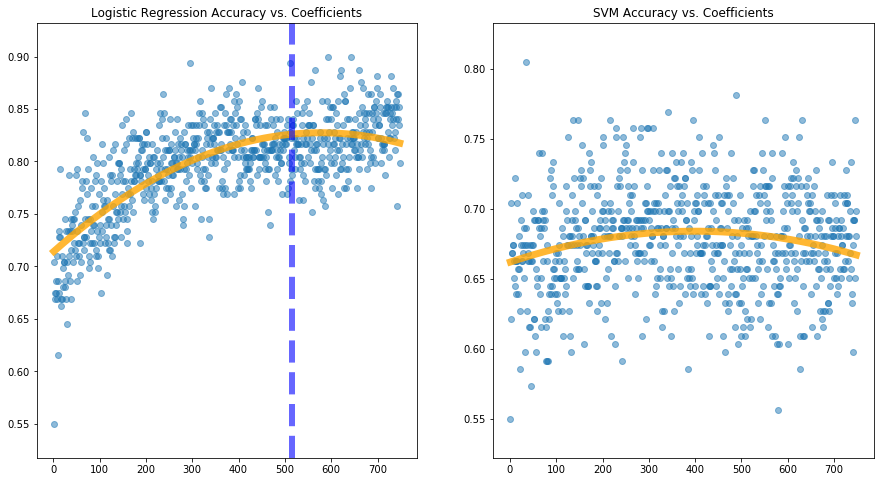

In [76]:
plt.clf()

fig, ax = plt.subplots(ncols = 2)

# Plotting results for the Logistic classifier.
ax[0].scatter(n_features, accuracy_logistic, alpha = 0.5)
fitted_values_logistic = [np.poly1d(np.polyfit(n_features, accuracy_logistic, 2))(n) for n in n_features]
ax[0].plot(n_features, fitted_values_logistic, linewidth = 7, color = 'orange', alpha = 0.8)
ax[0].set_title('Logistic Regression Accuracy vs. Coefficients')
ax[0].axvline(515, linestyle = '--', linewidth = 6, color = 'blue', alpha = 0.6)

# Plotting results for the svm classifier.
ax[1].scatter(n_features, accuracy_svm, alpha = 0.5)
fitted_values_svm = [np.poly1d(np.polyfit(n_features, accuracy_svm, 2))(n) for n in n_features]
ax[1].plot(n_features, fitted_values_svm, linewidth = 7, color = 'orange', alpha = 0.8)
ax[1].set_title('SVM Accuracy vs. Coefficients')

# Setting the figure properties.
fig.set_figheight(8)
fig.set_figwidth(15)
fig.savefig('/Users/dmpierre/Desktop/Accuracies.jpg')
plt.show()

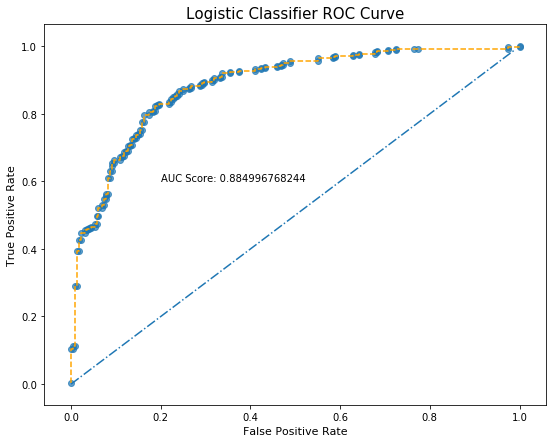

In [99]:
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score
from sklearn.feature_selection import f_classif

## Selecting features
selector = SelectKBest(f_classif, k = 500)
df_no_engagement = df_engagement[df_engagement.columns.difference(['high_engagement'])]
selected_features = selector.fit_transform(df_no_engagement, df_engagement['high_engagement'])  
indexes = selector.get_support(indices = True)                  
df_features_selected = df_no_engagement[df_no_engagement.columns[indexes]]

## Plotting the ROC Curve for the Logistic Regression
clf_logistic = LogisticRegression()

## Getting the train and test sets 
X_train, X_test, y_train, y_test = train_test_split(df_features_selected, 
                                                    df_engagement['high_engagement'], 
                                                    test_size=0.30, random_state = 105)

# Fitting the model
logistic = clf_logistic.fit(X_train, y_train)

log_pred, log_probs = logistic.predict(X_test), logistic.predict_proba(X_test)

## Getting the TPR and FPR
fpr, tpr, thresholds = roc_curve(y_test, log_probs[:,1], pos_label = 1)
auc_score = roc_auc_score(y_test, log_probs[:, 1])
    
## Plotting
plt.clf()
fig, ax = plt.subplots()

# Plotting the FPR, TPR and Base Line
ax.scatter(fpr, tpr, alpha = 0.7)
ax.plot(fpr, tpr, linestyle = 'dashed', color = 'orange')
ax.plot(np.arange(0, 1, 0.01), np.arange(0, 1, 0.01), linestyle = 'dashdot')
ax.set_xlabel('False Positive Rate', fontsize = 11), ax.set_ylabel('True Positive Rate', fontsize = 11)

ax.set_title('Logistic Classifier ROC Curve', fontsize = 15)

ax.text(0.2, 0.6, 'AUC Score: '+str(auc_score))
fig.set_figheight(7)
fig.set_figwidth(9)
fig.savefig('/Users/dmpierre/Desktop/ROC_curve.jpg')
plt.show()


## VI. FEATURE SELECTION IN CLASSIFICATION CONTEXT

In [63]:
## Inspect most important features
from sklearn.feature_selection import f_classif

# Create a dataframe to store the relevant p-values
p_vals_dict_engagement = pd.DataFrame.from_dict({}, orient='index')

# Start at i = 0 for the loop
i = 0    
for idx, pval in zip(indexes, selected_features[1]):
    p_vals_dict_engagement.loc[i, 'feature'] = df_no_engagement.columns[idx]
    p_vals_dict_engagement.loc[i, 'pval'] = pval
    i = i+1



In [64]:
p_vals_dict_engagement.sort_values('pval')

,feature,pval
0,Abortion,0.000000
332,Reporter,0.000000
331,Repeal,0.000000
330,Remains,0.000000
329,Relationship,0.000000
328,Reinstate,0.000000
327,Refusing,0.000000
326,Reels,0.000000
325,Reeling,0.000000
324,Records,0.000000


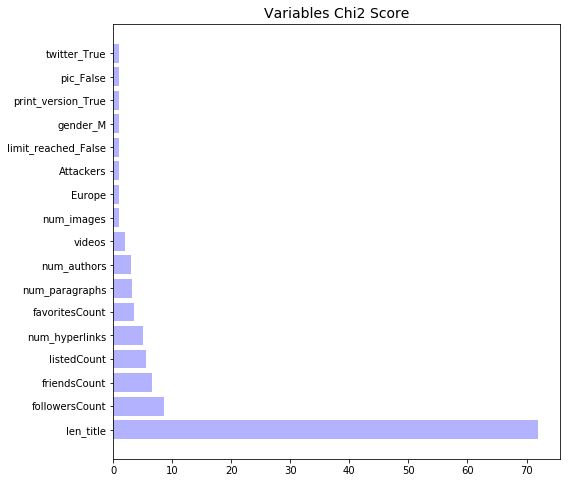

In [77]:
# Plot Horizontal Bar hist again
plt.clf()
fig, ax = plt.subplots()

sorted_dict_engagement = p_vals_dict_engagement.sort_values('pval', ascending = False)
features_names_engagement = sorted_dict_engagement.iloc[:17,0]
y_position = np.arange(features_names_engagement.shape[0])
p_vals_engagement = sorted_dict_engagement.iloc[:17, 1]
#p_vals_engagement = [np.log(p) for p in p_vals_dict_engagement]

ax.barh(y_position, p_vals_engagement, align='center', color='blue', alpha = 0.3)
ax.set_yticks(y_position)
ax.set_yticklabels(features_names_engagement)
ax.set_title('Variables Chi2 Score', fontsize = 14)

fig.set_figheight(8), fig.set_figwidth(10)
fig.savefig('/Users/dmpierre/Desktop/Chi2Score.jpg')
plt.show()

Confusion matrix, without normalization
[[186  43]
 [ 51 226]]


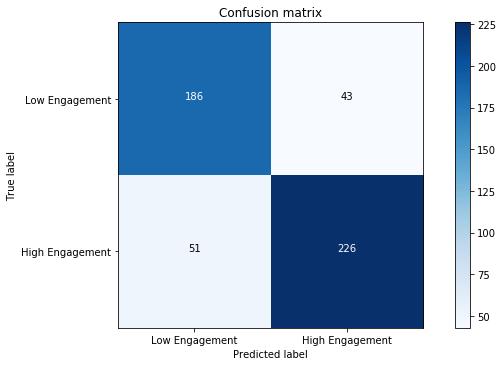

In [120]:
## Plotting the Confusion Matrix
plt.clf()
from sklearn.metrics import confusion_matrix
import itertools

def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=0)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    
cm = confusion_matrix(y_test, log_pred)
plot_confusion_matrix(cm, ['Low Engagement', 'High Engagement'], normalize=False)
plt.rcParams["figure.figsize"] = (8, 5)
plt.savefig('/Users/dmpierre/Desktop/ConfMat.jpg')
plt.show()


# V. HYPER-PARAMETERS TUNING AND VALIDATION STRATEGIES

In [89]:
### Hyperparameter tuning for the model that seems to work best: Logistic Regression

log_clf = LogisticRegression()

log_param_grid = [
    {'penalty':['l1', 'l2'], 
     'C':[0.1, 0.5, 1, 2], 'fit_intercept':[False, True]}
]

# Launching GridSearch
log_gridsearch = GridSearchCV(log_clf, log_param_grid, 'accuracy', cv = KFold(n_splits=3))
log_gridsearch.fit(df_no_engagement, df_engagement['high_engagement'])
df_results_grids_log = pd.DataFrame(log_gridsearch.cv_results_)
df_results_grids_log[df_results_grids_log['rank_test_score']==1]

,mean_fit_time,mean_score_time,mean_test_score,mean_train_score,param_C,param_fit_intercept,param_penalty,params,rank_test_score,split0_test_score,split0_train_score,split1_test_score,split1_train_score,split2_test_score,split2_train_score,std_fit_time,std_score_time,std_test_score,std_train_score
7,0.071131,0.007657,0.719454,0.959964,0.5,True,l2,"{u'penalty': u'l2', u'C': 0.5, u'fit_intercept...",1,0.704626,0.949288,0.692171,0.961744,0.761566,0.968861,0.001883,0.000393,0.030208,0.008089


In [90]:
log_gridsearch.best_params_

{'C': 0.5, 'fit_intercept': True, 'penalty': 'l2'}

In [96]:
from sklearn.ensemble import BaggingClassifier

kf = KFold(n_splits=4)
accuracy_scores = [] 

df_features_selected['high_engagement'] = df_engagement['high_engagement']

for train, test in kf.split(df_features_selected):
    
    # Taking out the high engagement column
    y_train, y_test = df_features_selected['high_engagement'].iloc[train], df_features_selected['high_engagement'].iloc[test]
    x_train, x_test = df_features_selected[df_features_selected.columns.difference(['high_engagement'])].iloc[train], df_features_selected[df_features_selected.columns.difference(['high_engagement'])].iloc[test]
 
    # Setting up a Bagging Classifier with the Logistic Regression
    clf_log = BaggingClassifier(base_estimator = 
                                LogisticRegression(),
                                n_estimators=300)
    predictions = clf_log.fit(x_train, y_train).predict(x_test)
    print str(accuracy_score(predictions, y_test))
    accuracy_scores.append(accuracy_score(predictions, y_test))

/Users/dmpierre/anaconda/lib/python2.7/site-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


0.741706161137
0.75355450237
0.805225653207
0.78622327791


In [122]:
np.var(accuracy_scores)

0.00064094560871465938